## Tutorial: Circuits II
 * Defining custom pulse-based gates using `PulsedGate`
 * Pulse gate caching
 * `Measurement` gates
 * Atom Transport
 * Example: Quantum Teleportation!

### Defining a pulsed gate from a pulse profile in a file

 * Import data file into array (`rabi` and `det`). The pulse shape comes from [1].
 * Normalize arrays relative to the max Rabi frequency
 * Prepare `PulsedGate` from the arrays


[1] Mohan, M., de Keijzer, R., & Kokkelmans, S. (2023). Robust control and optimal Rydberg states for neutral atom two-qubit gates. Physical Review Research, 5. https://doi.org/10.1103/PhysRevResearch.5.033052

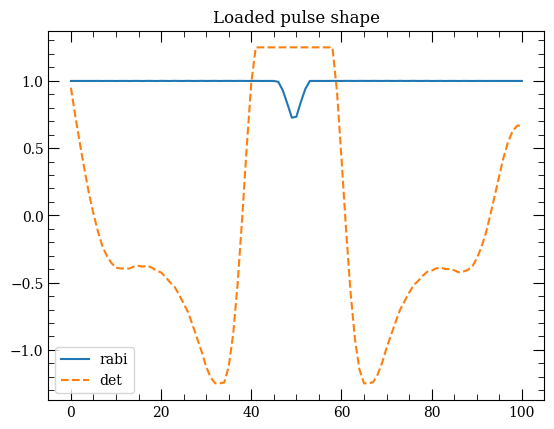

In [4]:
import numpy as np
import pulser.pulse
from rysp.core.circuit.pulses import Pulse_from_file, PulsedGate
import matplotlib.pyplot as plt

from rysp.core.experiment import ExperimentSetup
exp = ExperimentSetup.fromFile('template_hardware_pulsed.json')

rabi_freq = exp.rabi_freq[('1', 'r')]

# TODO: do relative dirs
# Loading the time dependent rabi frequencies and detunings
rabi = np.loadtxt('rabi.dat')
det = np.loadtxt('det.dat')
max_rabi = np.max(rabi)

# Normalizing the values to the maximum rabi frequency
rabi = rabi/max_rabi
det = det/max_rabi

# Plotting the curve profiles
plt.plot(rabi, label='rabi')
plt.plot(det, label='det', linestyle='--')
plt.legend()
plt.title("Loaded pulse shape")
plt.show()

# Preparing a PulsedGate from the arrays
pulse_wave = Pulse_from_file(rabi, det, 10/rabi_freq * 1e9) # TODO: why the '10' term?
pulse = PulsedGate()
pulse.new_channel('ryd', ('1', 'r'))
pulse.add_pulse(pulse=pulse_wave, channel='ryd', target=0)
pulse.add_pulse(pulse=pulse_wave, channel='ryd', target=1)
pulse._compile_pulses()
pulse.custom_repr = r'box {$CC$} ({targets});'

Loading the custom `PulsedGate` into the `QuantumCircuit`

In [5]:
from rysp.core.circuit import QuantumCircuit
from rysp.core.circuit.gatedictionary import GateDictionary

qc = QuantumCircuit('pulsed')
qc.add_to_dictionary(pulse, 'CC', 'pulsed', None)

sg = GateDictionary(exp)
sg.load_gate(qc, 'X')


Now the circuit is loaded with this `'CC'` gate, and can be used later by calling .add_operation

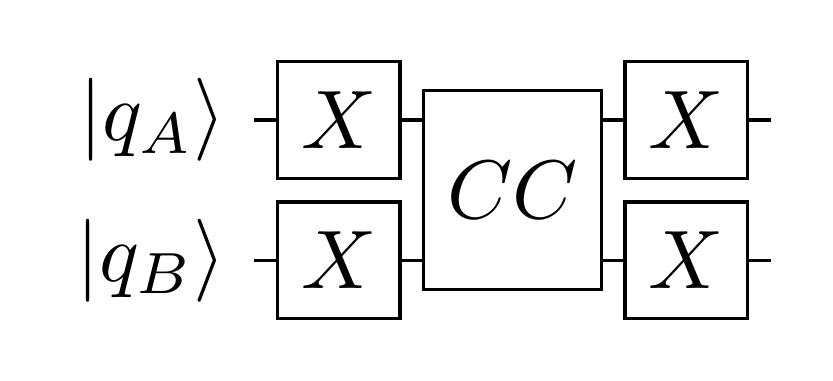

In [6]:
qc.reset()

qc.add_operation('X', ['A'])
qc.add_operation('X', ['B'])

qc.add_operation('CC', ['A', 'B'])

qc.add_operation('X', ['B'])
qc.add_operation('X', ['A'])

from rysp.utils.visualize import plot_quantum_circuit
from IPython.display import Image
imgname = plot_quantum_circuit(qc, {'A':'q_A', 'B': 'q_B'}, keepfiles=True, img_dir='.')
Image(filename=imgname, retina=True)

Since the `CC` operation was defined over multiple targets, the circuit plotter shows it in a multi-qubit gate representation.

This time, we have also used the flag `keepfiles=True`, meaning that the plotter will keep the pdf compilation files under `img_dir`. The generated files are *.tex, *.png and *.pdf.

Using the flag `show_pulsed=True` we can see the pulse profile on the circuit itself 

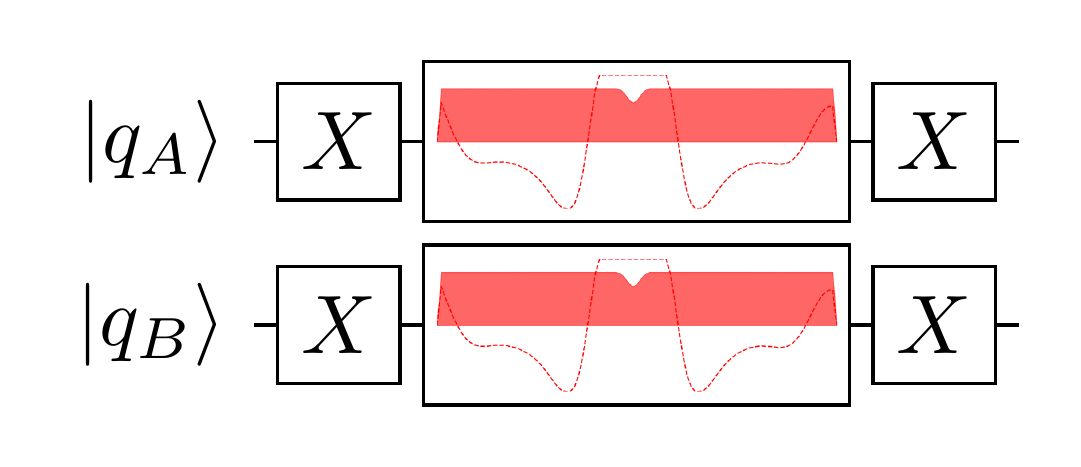

In [7]:
from rysp.utils.visualize import plot_quantum_circuit
from IPython.display import Image

imgname = plot_quantum_circuit(qc, {'A':'q_A', 'B': 'q_B'}, 
                               keepfiles=True, 
                               img_dir='_generated_img', 
                               show_pulsed=True)

Image(filename=imgname, retina=True)

### Caching the gates

The time-dependent evolution has, by default, a time resolution of $1\, ns$. A single $\pi$ rotation on the clock transition takes $\sim\mu s$, meaning that simple evolutions require $1000$'s of steps. With more atoms the simulations take considerably more time. Thus, we want to cache the `PulsedGate` evolutions to speedup the simulations. 

By ignoring crosstalks that may arise from gates that leave some population on the rydberg state, we further enhance the simulation speed by only acurately evolving for a  system size corresponding to the gate size. 

This can also be done in noisy scenarios, which we get to in the tutorial [`Noisy Circuits`](files/../Noisy%20Circuits.ipynb) .

In order to generate the cached version of a gate we need to call `Simulator.cache_gate_propagator` 

As an example, lets cache the CC gate. First we need to define a lattice where to generate the cached propagator on.

In [8]:
from rysp.core.experiment import AtomSystem
from rysp.core.simulation import Simulator

# Define the lattice where to cache the propagator
lattice = AtomSystem()
lattice_unit = 4e-6
atom = exp.get_atom()
lattice.add_atom('0', atom, lattice_unit*np.array([0,0,0]))
lattice.add_atom('1', atom, lattice_unit*np.array([1,0,0]))

# The CC Pulsed gate is the `pulse` object 

print(f"Cached propagator is {pulse.cached_propagator}")
Simulator.cache_gate_propagator(pulse, lattice, exp)
print(f"Cached propagator is {type(pulse.cached_propagator)}")

Cached propagator is None
Cached propagator is <class 'qutip.qobj.Qobj'>


The `.cache_gate_propagator` method saves the propagator on the PulsedGate object itself through the method `PulsedGate.cache_gate`. In this way, it can be directly used at simulation time. It also generates the state integrators, useful to compute state loss probabilities when noise is considered.

The lattice configuration and other simulation configurations (noise parameters) at cache time are also saved into the `PulsedGate` object, and these are later compared to the configuration at simulation run time, to assert if the cached propagator is appropriate.

The `StandardGate` object provides a way to directly load the `QuantumCircuit` with cached gates. Given a `lattice_unit` parameter, it will automatically generate a default lattice (5 qubits in cross shape). It will generate the gate propagators in parallel.

In [9]:
sg = GateDictionary(exp)
sg.load_cached_qc(qc, ['X','Xr', 'H', 
                       'Z', 'CX', 'CZ'], 
                  exp, None, lattice_unit)


### Measurement gates
We need to define what kind of measurement is done on the atoms. With the default method you can set the `wait_time` and which state is projected during measurement. 

In [10]:
from rysp.core.circuit import Measurement
qc.add_to_dictionary(Measurement(), 'M', 'pulsed', 
                     ['measurement variable'])


### Example: Teleportation protocol

We will use atom transport to move atom B away after the entanglement operation. The `AtomTransport` operation also allows you to define the transport method. The default method is called `direct`, which simply moves the atoms with a constant speed of $0.5\,\mu m/\mu s$

Here we define the atomic system. After entangling atom $A$ with $B$, we move $B$ far away.


In [11]:
from rysp.core.circuit import AtomTransport

# preparing the atom system
atomsys = AtomSystem()
atom = exp.get_atom()
positions = {'A': lattice_unit*np.array([0,0,0]),
             'B': lattice_unit*np.array([1,0,0]),
             'T': lattice_unit*np.array([0,1,0])}
atomsys.add_atom('A', atom, positions['A'])
atomsys.add_atom('B', atom, positions['B'])
atomsys.add_atom('T', atom, positions['T'])

new_pos_b = lattice_unit*np.array([100,0,0])

# Defining the operation to move B far from A
transport = AtomTransport({'B':new_pos_b})
transport.set_representation('box {{Move\\\\to Narnia}} {targets}; align -;') # changing the latex representation
theta = 2*np.pi * 3/5
phi = 2*np.pi * 1/8 

Defining the quantum teleportation circuit. 
1. Entangling A and B
2. Move B far away
3. Prepare some custom state on atom T: $\ket{\psi}_T=R_z(\phi)R_x(\theta)\ket{0}_T$
4. Couple T to A and prepare for measurement
5. Measure atoms A and T; load measurement results into variables $m_A$ and $m_T$
6. Execute X/Z gates on B depending on the measurement results to recover state on atom B $\ket{\psi}_B$ 
7. Invert state creation circuit $(R_z(\phi)R_x(\theta))^\dagger=R_x(-\theta)R_z(-\phi)$. 

If the state on B ends up $\ket{0}$, the teleportation protocol is successful!


In [12]:
qc.reset() # if this cell ends up being run more than once, this makes sure that the circuit doesn't have duplicated gates by resetting the circuit

# 1. prepare Bell state between A and B
qc.add_operation('H', ['A'])
qc.add_operation('CX', ['A', 'B'])

# 2. move atom B far away
qc.add_operation(transport, ['B'])

# 3. prepare some state on atom T
rx = sg.RX('01', theta)
rx.set_representation('box {{$R_X(\\theta)$}} {target};')# changing the latex representation
rz = sg.RZ('01', phi)
rz.set_representation('box {{$R_Z(\\phi)$}} {target};')
qc.add_operation(rx, ['T'])
qc.add_operation(rz, ['T'])

# 4. Coupling T to A; preparing for measurement
qc.add_operation('CX', ['T','A'])
qc.add_operation('H', ['T'])

# 5. Measurement
# The 'args' define which circuit variable
# does the measurement outcome feed into
qc.add_operation('M', ['T'], args='mT')
qc.add_operation('M', ['A'], args='mA')


# 6. Parameter controlled gates
# Here we start defining classically controlled gates 
# using circuit variables
from rysp.core.circuit.pulses import ParametrizedPulsedGate

# If the bit is 1, then return a Z gate, otherwise do nothing
def classic_z(b):
    if b==1: return sg.Z('01') 
    return None

# The 'True' tag indicates if the output of the parametrized gate can be cached
classicZ = ParametrizedPulsedGate(classic_z, ['b'], True)
classicZ.set_representation('box {{$Z_T$}} {target} | var;') # changing the latex representation
qc.add_operation(classicZ, ['B'], args={'mT':0})

# If the bit is 1, then return a X gate, otherwise do nothing
def classic_x(b):
    if b==1: return sg.X('01') 
    return None

classicX = ParametrizedPulsedGate(classic_x, ['b'], True)
classicX.set_representation('box {{$X_A$}} {target} | var;')
qc.add_operation(classicX, ['B'], args={'mA':0})

# 7. At the end of the protocol we expect the state to be T
# So, lets reverse the operation that generated T
# The protocol was successful if the outcome is |0>
rz1 = sg.RZ('01', -phi) # inverse Rz gate
rz1.set_representation('box {{$R_Z(-\\phi)$}} {target};')

rx1 = sg.RX('01', -theta) # inverse Rx gate
rx1.set_representation('box {{$R_X(-\\theta)$}} {target};')

qc.add_operation(rz1, ['B'])
qc.add_operation(rx1, ['B'])



Now we can visualize the circuit!

requires $\LaTeX$ installed on the system 

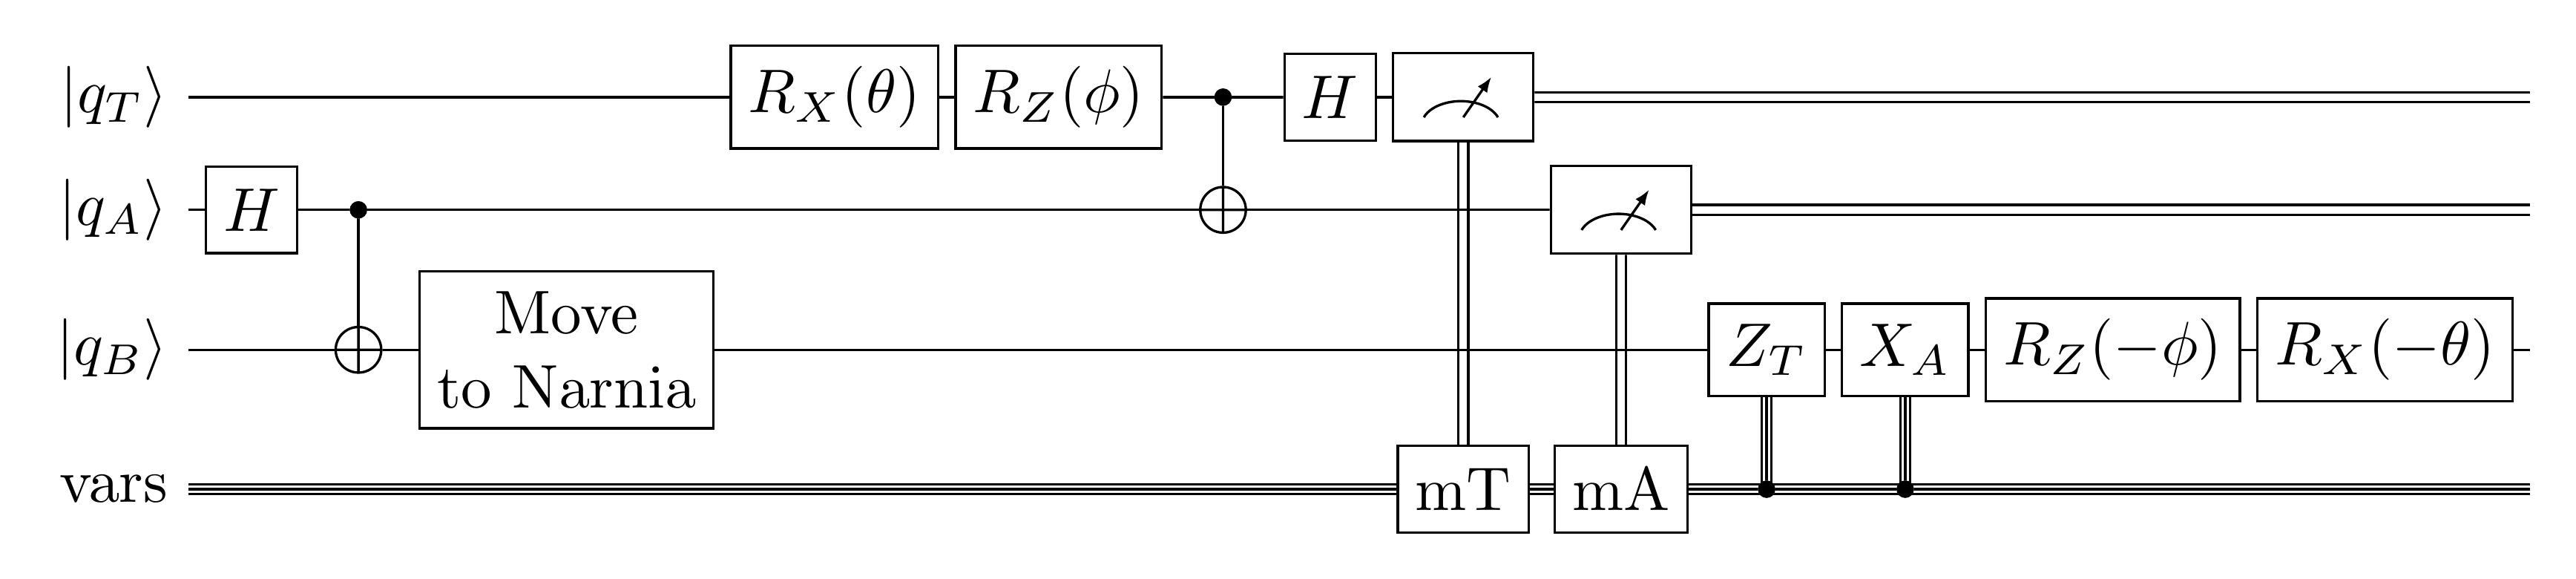

In [13]:
from rysp.utils.visualize import plot_quantum_circuit
from IPython.display import Image
img = plot_quantum_circuit(qc, {'T':'q_T', 'A':'q_A', 'B':'q_B'}, show_vars=True)
Image(filename=img, retina=True)

We can run the simulation over multiple runs to check if the protocol works under randomized measurements. Use `Simulator.run_circuit_statistical` to achieve this. 

This function paralelizes the runs over multiple cores to take full advantage of the computing resources.

At the end we compute the overlap with the ideal state, without imperfections. Here we still have to deal with imperfect blockade.

In [ ]:
from rysp.core.simulation import Simulator
from timeit import default_timer as timer

sim = Simulator(exp, atomsys)

n_experiments = 50 

data = []

final_states = []

print("Running simulation...")
start = timer()
cvars, states = sim.run_circuit_statistical(qc, 
                                            num_runs=n_experiments,
                                            save_states=True, 
                                            track_end_state=True,
                                            runtime_caching=True)
print(f"Simulation took {timer()-start:.3} s")


for mA, mT, state in zip(cvars['mA'], cvars['mT'], states):
    overlap = (atomsys.ket(('B', '0')).dag() * state ).norm()
    data.append([mA, mT, overlap])
    

The average fidelity is computed through a geometric mean

In [ ]:

# calculating the geometric average over the 50 samples
gavg = 1
for _, _, overlap in data:
    gavg *= overlap
gavg = np.power(gavg, 1/len(data))
print(f"Fidelity average: {gavg:.3}")